<a href="https://colab.research.google.com/github/Hyewon-Git/2021_HUFS_NLP/blob/main/%ED%98%9C%EC%9B%90_NLP_04_03_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evn

In [ ]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [ ]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# 입력 및 Vocab

In [ ]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [ ]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [ ]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [ ]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# RNN

## return sequence=False, return_state=False

In [ ]:
# rnn 문장을 데표하는 값으로 나옴
rnn_11 = tf.keras.layers.SimpleRNN(units=5)
output_11 = rnn_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[0.01161555 0.02362226 0.00568394 0.06808266 0.04145366]], shape=(1, 5), dtype=float32)


In [ ]:
# rnn weights
weights = rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b= weights[2]
print( Wx.shape) #(d_models, unit)
print(Wh.shape) #(unit, unit)
print(b.shape)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)
rnn_12 = tf.keras.layers.SimpleRNN(units=5, return_sequences= True)
output_12 = rnn_12(hidden) #(bs, seq,units)
print(output_12)

tf.Tensor(
[[[-0.00323643  0.02167398 -0.01312704  0.01852052  0.00828851]
  [-0.01788524 -0.0159944   0.03378549 -0.00939829  0.02647523]
  [ 0.04990628  0.03171325  0.02272197  0.03906418  0.00540583]
  [-0.0618528   0.03231876  0.07561149  0.00386349 -0.00172946]
  [ 0.04312672 -0.03201946  0.05161034  0.04581791  0.03327593]
  [ 0.00123462  0.03464187  0.08745971  0.00467893 -0.0410229 ]
  [-0.00617449 -0.01038853  0.08965419  0.06859078  0.0182435 ]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [ ]:
# (return_state=True)
rnn_13 = tf.keras.layers.SimpleRNN(units=5, return_state=True)
output_13, fw_h_13 = rnn_13(hidden)  # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.02670264 -0.00038221 -0.12432419  0.01665503 -0.06099923]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.02670264 -0.00038221 -0.12432419  0.01665503 -0.06099923]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)
rnn_14 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14 = rnn_14(hidden)  # (bs, seq, units), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[ 0.00951978 -0.01314144 -0.00589061  0.01881828  0.00137008]
  [-0.02204679 -0.02032987  0.01575966  0.03513111 -0.0223612 ]
  [ 0.01554222 -0.04719219  0.01048455  0.0388689  -0.03081334]
  [-0.04688481  0.00162127  0.00477716 -0.01861283 -0.04350326]
  [ 0.03181777 -0.04759053  0.02972677 -0.01944566  0.00785506]
  [-0.07925099 -0.01210518  0.01060691  0.00239983 -0.02345758]
  [ 0.01439055 -0.00074061  0.05117338 -0.0614779   0.00071227]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.01439055 -0.00074061  0.05117338 -0.0614779   0.00071227]], shape=(1, 5), dtype=float32)


## init hidden state

In [ ]:
# rnn_11 with fw_h_13
rnn_11(hidden, initial_state=(fw_h_13)) #(bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.00152348, -0.03819767,  0.18813123,  0.16934818,  0.0112766 ]],
      dtype=float32)>

In [ ]:
# rnn_12 with fw_h_14
rnn_12(hidden, initial_state=(fw_h_14)) #(bs, n_seq,units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.05595651,  0.05421422, -0.01073319,  0.06019097,
          0.02517956],
        [-0.07488797,  0.02739964,  0.07082541, -0.00533941,
          0.03317471],
        [ 0.07407533, -0.01731026,  0.0667059 ,  0.04324479,
          0.04552307],
        [-0.02643368,  0.07518677,  0.11036134, -0.00582068,
         -0.04771021],
        [ 0.02535339, -0.02027231,  0.06244824,  0.11815378,
          0.05824921],
        [-0.03185819,  0.00918599,  0.1464781 , -0.02525222,
         -0.05527409],
        [ 0.05999442, -0.03103417,  0.10347962,  0.10115581,
          0.00275798]]], dtype=float32)>

In [ ]:
# rnn_13 with fw_h_13
rnn_13(hidden, initial_state=(fw_h_13)) #(bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.14932072,  0.11725824, -0.21856028, -0.16309005,  0.18373224]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.14932072,  0.11725824, -0.21856028, -0.16309005,  0.18373224]],
       dtype=float32)>]

In [ ]:
# rnn_14 with fw_h_14
rnn_14(hidden, initial_state=(fw_h_14)) #(bs, n_seq, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.0395823 , -0.01680315, -0.02160325, -0.03295869,
           0.03671723],
         [-0.01670021,  0.02330631,  0.06334502,  0.00706623,
           0.0177265 ],
         [ 0.01257983, -0.02054661, -0.03843518,  0.00660486,
           0.01851024],
         [-0.04247411,  0.04587003,  0.02653741,  0.01530088,
           0.01106921],
         [ 0.06553783, -0.00589802, -0.02908621, -0.01064507,
           0.02037552],
         [-0.06836148, -0.01215764,  0.0059845 ,  0.07536106,
           0.00944641],
         [ 0.04560515,  0.02935247,  0.01476286, -0.02518846,
          -0.04412011]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.04560515,  0.02935247,  0.01476286, -0.02518846, -0.04412011]],
       dtype=float32)>]

# LSTM

## return sequence=False, return_state=False

In [ ]:
# lstm
lstm_11 = tf.keras.layers.LSTM(units=5)
output_11 = lstm_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[ 0.00983144  0.00677333  0.01250601 -0.00395866  0.00803152]], shape=(1, 5), dtype=float32)


In [ ]:
# lstm weights
weights = lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)
# (return_sequences=True)
lstm_12 = tf.keras.layers.LSTM(units=5, return_sequences=True)
output_12 = lstm_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[ 0.00252063  0.00440608  0.00057659  0.00345692  0.00227694]
  [ 0.00094497 -0.00082445  0.00513457  0.00237795 -0.00680039]
  [ 0.00618299  0.00351107  0.00575827  0.00653031 -0.00703923]
  [ 0.00196642  0.00232887  0.00043283  0.00295208 -0.00202692]
  [ 0.00390672  0.00657806  0.00089501  0.00622658  0.00086209]
  [ 0.00193729  0.00112221  0.00534334  0.0049387  -0.00779089]
  [-0.00057429  0.00104745  0.00346995  0.00298281 -0.004889  ]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [ ]:
# (return_state=True)
lstm_13 = tf.keras.layers.LSTM(units=5, return_state=True)
output_13, fw_h_13, fw_c_13 = lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units) ##요로케 state가 다르다
print(output_13)
print(fw_h_13)
print(fw_c_13)

tf.Tensor([[-0.01905471 -0.00646859 -0.00668064 -0.02151529 -0.02403497]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01905471 -0.00646859 -0.00668064 -0.02151529 -0.02403497]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.03810032 -0.0129107  -0.01329387 -0.04329779 -0.04815203]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)
lstm_14 = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14, fw_c_14 = lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)

tf.Tensor(
[[[-0.00159922  0.00107845 -0.00063869  0.00025247 -0.00057217]
  [ 0.00193241  0.00304301  0.00269774 -0.00559815 -0.00152864]
  [ 0.00178413  0.00309171  0.00259154 -0.0077432  -0.00613074]
  [ 0.00197758 -0.00015147  0.00297934 -0.0061507  -0.00720368]
  [-0.00059788  0.00168265  0.00279535 -0.00399814 -0.00573235]
  [ 0.00219329  0.00406804  0.00597546 -0.00839895 -0.00502785]
  [ 0.00190276  0.00363062  0.00732819 -0.00913288 -0.00533654]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.00190276  0.00363062  0.00732819 -0.00913288 -0.00533654]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.0038093   0.00724048  0.01463112 -0.01826086 -0.01062784]], shape=(1, 5), dtype=float32)


## init hidden state

In [ ]:
# lstm_11 with fw_h_13, fw_c_13
lstm_11(hidden, initial_state=[fw_h_13, fw_c_13]) # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.01332386, -0.01835001, -0.00570211, -0.0204051 , -0.00711428]],
      dtype=float32)>

In [ ]:
# lstm_12 with fw_h_14, fw_c_14
lstm_12(hidden, initial_state=[fw_h_14, fw_c_14]) # (bs,n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.00399983,  0.00801729,  0.00703665, -0.00382085,
         -0.00124561],
        [ 0.00207471,  0.0025133 ,  0.01086333, -0.0034085 ,
         -0.00913014],
        [ 0.00702795,  0.00645161,  0.01066868,  0.00194132,
         -0.00854924],
        [ 0.0026228 ,  0.00487202,  0.00455751, -0.00059059,
         -0.00301229],
        [ 0.00439067,  0.00871862,  0.00432657,  0.00344744,
          0.00025115],
        [ 0.00229503,  0.00289634,  0.00825317,  0.00277564,
         -0.00817197],
        [-0.00030517,  0.00249062,  0.0058535 ,  0.00132461,
         -0.00511776]]], dtype=float32)>

In [ ]:
# lstm_13 with fw_h_13, fw_c_13
lstm_13(hidden, initial_state=[fw_h_13, fw_c_14])  # (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.02021285, -0.00725981, -0.00701719, -0.02465678, -0.02621573]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.02021285, -0.00725981, -0.00701719, -0.02465678, -0.02621573]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.04043132, -0.01450089, -0.01395699, -0.04961585, -0.05250439]],
       dtype=float32)>]

In [ ]:
# lstm_14 with fw_h_14, fw_c_14
lstm_14(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-1.4419634e-03,  4.6840804e-03,  6.1914623e-03, -5.9641050e-03,
          -3.9009282e-03],
         [ 9.6485339e-04,  6.4016581e-03,  8.4660007e-03, -9.6409442e-03,
          -3.2786529e-03],
         [ 1.5146595e-04,  6.1237817e-03,  7.2979862e-03, -1.0267652e-02,
          -6.7571895e-03],
         [ 2.5424670e-05,  2.4009938e-03,  6.6182008e-03, -7.5563355e-03,
          -7.0650619e-03],
         [-2.6167138e-03,  3.8029549e-03,  5.4245228e-03, -4.7001638e-03,
          -5.1061772e-03],
         [ 2.7738381e-04,  5.7518808e-03,  7.7602793e-03, -8.6409608e-03,
          -4.1432995e-03],
         [ 1.6896227e-04,  4.9261432e-03,  8.4838532e-03, -9.0982793e-03,
          -4.3393010e-03]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00016896,  0.00492614,  0.00848385, -0.00909828, -0.0043393 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00033827,  0

In [ ]:
#큰차이는 없다!!  LSTM부터 시작해보기!!

# GRU

## return sequence=False, return_state=False

In [ ]:
# # bi GRU
gru_11 = tf.keras.layers.GRU(units=5)
output_11 = gru_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[-0.00822345 -0.01306884 -0.00893542  0.00600853 -0.01483085]], shape=(1, 5), dtype=float32)


In [ ]:
# bi GRU weights
weights = gru_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 3) (Wxr, Wxz, Wxg)
print(Wh.shape)  # (unit, unit * 3) (Whr, Whz, Whg)
print(b.shape)  # (2, unit * 3) (bxr, bxz, bxg),(bhr, bhz, bhg)

(4, 15)
(5, 15)
(2, 15)


## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)
gru_12 = tf.keras.layers.GRU(units=5, return_sequences=True)
output_12 = gru_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-5.55303134e-03  6.15098048e-04  2.42460333e-03  4.51902626e-03
   -2.29136925e-03]
  [-6.62358152e-03 -7.82439485e-03 -2.63045426e-04  4.08674218e-03
   -5.89761743e-03]
  [-1.20439725e-02 -4.78736265e-03 -7.79389055e-04  1.54595552e-02
   -1.42169483e-02]
  [-7.85878394e-04  4.24179435e-03 -2.73750350e-03  9.93530639e-03
   -1.23046534e-02]
  [-5.12868538e-03  1.19403587e-03 -9.47469380e-05  9.80010629e-03
   -9.90041066e-03]
  [-5.96865499e-03 -8.41745548e-03 -2.15776009e-03  7.07779732e-03
   -1.04319602e-02]
  [-4.04856075e-03 -1.81261101e-03 -9.02000931e-04  7.59084430e-03
   -1.07997712e-02]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [ ]:
# (return_state=True)



## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)


## init hidden state

In [ ]:
gru_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.00140842,  0.01592344, -0.01623747, -0.00670336, -0.01101907]],
      dtype=float32)>

In [ ]:
gru_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.00300019, -0.00323922, -0.01454308, -0.00958822,
          0.01849951],
        [-0.00319965, -0.00230684, -0.00040348,  0.0188137 ,
          0.02772161],
        [-0.01684529, -0.02090497, -0.00366238,  0.02805248,
          0.04653085],
        [-0.00582952, -0.00502904,  0.00368652,  0.0209058 ,
          0.02341765],
        [-0.01303946, -0.01359165, -0.00516605,  0.01199155,
          0.02483771],
        [-0.01180617, -0.00767625,  0.00535123,  0.03328608,
          0.03071455],
        [-0.00979845, -0.00366684,  0.01045386,  0.03020769,
          0.02639962]]], dtype=float32)>

In [ ]:
gru_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>]

In [ ]:
gru_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.00120912,  0.01436689, -0.00526015, -0.00245608,
           0.01752719],
         [ 0.00106435,  0.0148916 , -0.01622299, -0.01184704,
           0.01214018],
         [ 0.00249824,  0.02077618, -0.01704834, -0.01405097,
           0.03059548],
         [ 0.01132524,  0.01315177, -0.01130751, -0.0072835 ,
           0.01345716],
         [ 0.00543236,  0.0139883 , -0.00539421, -0.00206096,
           0.01916937],
         [ 0.00361664,  0.0148993 , -0.01673315, -0.01203724,
           0.01301165],
         [ 0.00488993,  0.01504152, -0.01344696, -0.01023171,
           0.01024941]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00488993,  0.01504152, -0.01344696, -0.01023171,  0.01024941]],
       dtype=float32)>]

# Bidirectional RNN

## return sequence=False, return_state=False

In [ ]:
# bi rnn
# rnn_11 = tf.keras.layers.SimpleRNN(units=5)
bi_rnn_11 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5))
output_11 = bi_rnn_11(hidden)  # (bs, units * 2)
print(output_11)


tf.Tensor(
[[ 0.18931128 -0.04154792  0.1876914  -0.11597452  0.03595337 -0.02349233
  -0.03035322  0.0510736   0.02881334 -0.00819293]], shape=(1, 10), dtype=float32)


In [ ]:
# bi rnn weights
weights = bi_rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)
bi_rnn_12 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True))
output_12 = bi_rnn_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[-4.76418762e-03 -1.70582142e-02 -3.61184683e-03 -3.42751504e-03
   -4.42533474e-03 -1.00385003e-01 -7.76819438e-02 -5.37737012e-02
    8.52689967e-02  9.21161026e-02]
  [ 7.91331194e-03  9.66492109e-03  3.81905362e-02 -3.35013457e-02
    7.75500163e-02  4.28700112e-02 -8.75423998e-02 -1.16562247e-01
   -6.32162839e-02 -1.20759485e-02]
  [ 7.81266950e-03 -7.50807449e-02 -1.15210898e-02 -1.36614116e-02
    2.26423144e-05 -9.25347283e-02 -1.95431504e-02 -4.64161336e-02
    3.58923711e-02  9.74665210e-02]
  [ 3.16398256e-02 -3.75990160e-02  6.13114052e-02 -6.75042626e-03
    1.49666090e-02  6.37501292e-03 -3.95679325e-02 -3.70524488e-02
   -5.05564213e-02 -2.16222480e-02]
  [ 4.64648195e-02 -4.43048850e-02  2.01959684e-02  3.57470848e-02
   -3.55377421e-02 -8.83258414e-03 -3.79141495e-02 -5.63808018e-03
    8.40390753e-03  3.35499309e-02]
  [ 5.85178584e-02  4.62395549e-02  8.14268366e-02 -3.47057730e-02
    5.22874407e-02 -7.80416280e-03 -5.67649268e-02 -2.12453175e-02
    3

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)
bi_rnn_13 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_rnn_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[ 0.00098553 -0.09506832 -0.04031752  0.0941245  -0.09733334 -0.01768726
   0.0558731  -0.12036287 -0.02208276  0.01707737]], shape=(1, 10), dtype=float32)
tf.Tensor([[ 0.00098553 -0.09506832 -0.04031752  0.0941245  -0.09733334]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01768726  0.0558731  -0.12036287 -0.02208276  0.01707737]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)
bi_rnn_14 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_rnn_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[ 0.00996201 -0.00267584 -0.00360272 -0.00869952 -0.00813484
    0.08439396 -0.08233969  0.02196166 -0.01683914  0.09967852]
  [-0.02642875  0.03627111  0.01586257  0.04202417  0.03213948
    0.0313338  -0.08055723  0.01728546  0.05026325  0.10042129]
  [-0.0163197   0.04476373 -0.06943747  0.03440892  0.07485872
    0.00466569 -0.0687737   0.02491838 -0.02911229  0.08178426]
  [ 0.04861628  0.00677399 -0.04211297 -0.06201398  0.10929528
   -0.00701199 -0.05750083 -0.04219229 -0.04207728  0.02703669]
  [ 0.05728203 -0.10602242 -0.00263633 -0.07374821  0.04395162
    0.05364475 -0.04018037 -0.03248807 -0.04328033  0.01899295]
  [-0.06497745 -0.07644276  0.07749152  0.00483667  0.01144473
    0.04157786 -0.03691922 -0.04236413  0.0565349   0.01457335]
  [-0.06706695 -0.02358202  0.02252599  0.0927903   0.0258527
    0.02188927 -0.01543856 -0.00782749  0.02094383  0.00220338]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[-0.06706695 -0.02358202  0.02252599  0.0927903   0.02

## init hidden state

In [ ]:
# bi_rnn_11 with fw_h_13, bw_h_13
bi_rnn_11(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2)


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.10081545, -0.04203923,  0.15114386, -0.12223297,  0.1654687 ,
        -0.05786587, -0.00688073,  0.1704233 ,  0.02012452,  0.01940287]],
      dtype=float32)>

In [ ]:
# bi_rnn_12 with fw_h_14, bw_h_14
bi_rnn_12(hidden, initial_state=[fw_h_14, bw_h_14])  # (bs, n_seq, units * 2)


<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-5.47017530e-02,  4.53841761e-02,  1.30953053e-02,
          8.63248855e-02, -1.24355620e-02, -7.22898096e-02,
         -1.18688822e-01, -1.52226448e-01,  2.18359418e-02,
          9.01035778e-03],
        [-2.08158977e-02,  1.06743097e-01, -1.43305836e-02,
          7.46826595e-03,  7.28393048e-02,  2.51983032e-02,
         -1.13067865e-01, -1.21754095e-01,  1.21386722e-04,
          1.23690382e-01],
        [-4.89185341e-02, -8.39299709e-03, -8.46743137e-02,
         -5.40397204e-02,  2.02228595e-03, -1.22256152e-01,
         -1.89860724e-02, -1.51290685e-01, -3.91912200e-02,
          1.92737151e-02],
        [-4.02511582e-02, -4.85951267e-02, -4.08993242e-03,
         -5.69273233e-02,  6.53308704e-02,  9.40772356e-04,
         -5.53555228e-02, -1.18762972e-02, -5.00134639e-02,
          1.30151793e-01],
        [-4.93813679e-02, -1.05396695e-01,  1.18560269e-02,
          3.30199562e-02,  4.02471423e-03, -9.29820165e-02,


In [ ]:
# bi_rnn_13 with fw_h_13, bw_h_13

In [ ]:
# bi_rnn_14 with fw_h_14, bw_h_14

# Bidirectional LSTM

## return sequence=False, return_state=False

In [ ]:
# lstm
bi_lstm_11 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5))
output_11 = bi_lstm_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.01847664 -0.01717866 -0.01455096 -0.00403581  0.00520225  0.00247622
   0.00704844  0.00227592 -0.00264071 -0.00672963]], shape=(1, 10), dtype=float32)


In [ ]:
# lstm weights
weights = bi_lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)
bi_lstm_12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True))
output_12 = bi_lstm_12(hidden)  # (bs, seq, units * 2)
print(output_12)

tf.Tensor(
[[[-0.00631327  0.00020226 -0.00249581 -0.00222378  0.00160725
   -0.00153126  0.0051608   0.01623868 -0.00138526 -0.00184595]
  [-0.0001583  -0.00177069  0.00636381  0.00476604  0.0052069
    0.00422231  0.00383904  0.01914648  0.00116657 -0.00043464]
  [-0.0062639  -0.00064289  0.00462585  0.00631612  0.00794407
   -0.00317268  0.00138541  0.0158445  -0.00347207 -0.00254659]
  [-0.00425812  0.00132639  0.00020326  0.00859033  0.00416241
    0.00119956 -0.00057372  0.00453301  0.00108235  0.00030032]
  [-0.00955186  0.0014321  -0.0024945   0.0039799   0.00525159
    0.0003114   0.00297156  0.00970575 -0.00076363 -0.00191017]
  [-0.00279158 -0.0006622   0.00623789  0.00911862  0.00841716
    0.00671738  0.00150737  0.00944808  0.00333584  0.00035412]
  [-0.00274947 -0.00060721  0.00312654  0.01213499  0.00786342
    0.00029456 -0.00075656  0.00234319  0.00150466 -0.00042868]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [ ]:
# (return_state=True) !!복잡해짐
bi_lstm_13 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_state=True))
output_13, fw_h_13, fw_c_13, bw_h_13, bw_c_13 = bi_lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)
print(bw_h_13)
print(bw_c_13)

tf.Tensor(
[[ 0.00411173 -0.00831241  0.01692605 -0.00510522 -0.00688484 -0.0215863
   0.00485156  0.01411392 -0.00410303  0.01348552]], shape=(1, 10), dtype=float32)
tf.Tensor([[ 0.00411173 -0.00831241  0.01692605 -0.00510522 -0.00688484]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00827796 -0.0165672   0.0335795  -0.01014036 -0.01373773]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.0215863   0.00485156  0.01411392 -0.00410303  0.01348552]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.04365217  0.00974696  0.02803824 -0.0081831   0.02713963]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)
bi_lstm_14 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, fw_c_14, bw_h_14, bw_c_14 = bi_lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)
print(bw_h_14)
print(bw_c_14)

tf.Tensor(
[[[ 0.00153193  0.00116307  0.00563109  0.00341496 -0.00391378
    0.02067887 -0.00752415 -0.00618206 -0.00835574  0.00873399]
  [ 0.00631582  0.00197633  0.00906464 -0.00529832  0.00133102
    0.01733007 -0.01035947 -0.00423516 -0.00439696  0.01063575]
  [ 0.01177119  0.00348707  0.02075526 -0.00501861 -0.00160673
    0.01720648 -0.0053312  -0.00738487 -0.00833478  0.00841468]
  [ 0.0107502   0.00184673  0.01488181 -0.00562807 -0.00325063
    0.00835131 -0.00098437 -0.00509251 -0.00166755  0.00354956]
  [ 0.00970421  0.00266808  0.0171707  -0.00103273 -0.00734383
    0.00939877 -0.00551686 -0.00363663 -0.00331604  0.005113  ]
  [ 0.01244691  0.00321246  0.01780605 -0.00878723 -0.00190793
    0.00455827 -0.00720637 -0.00054807  0.00176321  0.00557647]
  [ 0.0140338   0.00395908  0.01727484 -0.00995408 -0.00330339
    0.00311928 -0.00075476 -0.00218782 -0.00046304  0.00175497]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.0140338   0.00395908  0.01727484 -0.00995408 -0.0

## init hidden state

In [ ]:
# bi_lstm_11 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_11(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.01707753, -0.01754141, -0.01247944, -0.00506948,  0.00826678,
         0.00047937,  0.01026874,  0.00383332, -0.00487527, -0.00381998]],
      dtype=float32)>

In [ ]:
# bi_lstm_12 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_12(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[ 3.8993633e-03,  2.4127972e-03,  8.7280525e-03, -7.2026686e-03,
         -9.4327726e-04,  3.4019009e-03,  4.5521851e-03,  1.7757371e-02,
         -5.3312341e-03, -7.4921385e-04],
        [ 7.6569393e-03, -7.2397041e-04,  1.3515559e-02,  2.6278330e-03,
          3.2623969e-03,  1.0141648e-02,  2.8050197e-03,  2.0655528e-02,
         -3.6816448e-03,  8.8700285e-04],
        [-4.9230433e-04, -3.6496719e-04,  9.0595642e-03,  5.6683570e-03,
          6.5368218e-03,  4.2828633e-03, -2.2079606e-04,  1.7099027e-02,
         -9.2676552e-03, -8.7199657e-04],
        [ 2.0906157e-04,  1.1548243e-03,  2.9362852e-03,  8.6766612e-03,
          3.1324779e-03,  1.0239310e-02, -2.9020996e-03,  5.2829823e-03,
         -5.6805303e-03,  2.5658421e-03],
        [-6.1332267e-03,  1.0090502e-03, -9.3549414e-04,  4.3840152e-03,
          4.4985656e-03,  1.1570473e-02, -3.0943463e-04,  9.5874285e-03,
         -8.6442102e-03,  1.1631391e-03],
        

In [ ]:
# bi_lstm_13 with fw_h_13, fw_c_13, bw_h_13, bw_c_13

In [ ]:
# bi_lstm_14 with fw_h_14, fw_c_14, bw_h_14, bw_c_14

# Bidirectional GRU

## return sequence=False, return_state=False

In [ ]:
# bi GRU

In [ ]:
# bi GRU weights

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)

## init hidden state

In [ ]:
# bi_gru_11 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_12 with fw_h_14, bw_h_14

In [ ]:
# bi_gru_13 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_14 with fw_h_14, bw_h_14

# RNN 모델

In [ ]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    RNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    ########################################
    rnn_1 =tf.keras.layers.SimpleRNN(units=128 , return_sequences=True)#return_sequences=True를 해줘야 다음 layer을 쌓을수있음
    hidden = rnn_1(hidden) #(bs, 128)

    rnn_2  =tf.keras.layers.SimpleRNN(units=128, return_sequences=True)
    hidden = rnn_2(hidden)
    ########################################

    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

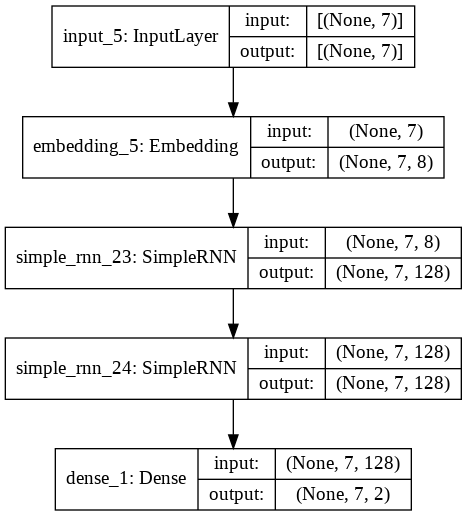

In [ ]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs)

array([[0.49205196, 0.50794804]], dtype=float32)